In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import datetime

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [42]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map_wind(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        qk = plt.quiverkey(qu, 0.9, 0.03, 4, '4 m s$^{-1}$',
                           labelpos='E', coordinates='figure')
        
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.tight_layout()
    #plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/conny_examples/850hpa_rh_ERA5_peru.png')

In [4]:
def draw_map(t, lat, lon):
    f=plt.figure(figsize=(15,10))
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree())
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.colorbar()
    plt.show()

In [13]:
hour = '/media/ck/Elements/SouthAmerica/ERA5/monthly/pressure_levels/synop/ERA5_monthly_pl_2016_synop.nc'

dat = xr.open_dataset(hour)

In [14]:
dat

<xarray.Dataset>
Dimensions:    (latitude: 66, level: 17, longitude: 73, time: 96)
Coordinates:
  * longitude  (longitude) float32 -83.0 -82.3 -81.6 -80.9 ... -34.0 -33.3 -32.6
  * latitude   (latitude) float32 5.5 4.8 4.1 3.4 ... -37.9 -38.6 -39.3 -40.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-01T21:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-05 19:17:22 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [15]:
dat = uda.flip_lat(dat)

In [16]:
mmean = dat.sel(level=200).isel(time=(dat['time.month']==3)).mean('time')

In [18]:
mmean

<xarray.Dataset>
Dimensions:    (latitude: 66, longitude: 73)
Coordinates:
  * longitude  (longitude) float32 -83.0 -82.3 -81.6 -80.9 ... -34.0 -33.3 -32.6
  * latitude   (latitude) float32 -40.0 -39.3 -38.6 -37.9 ... 3.4 4.1 4.8 5.5
    level      int32 200
Data variables:
    d          (latitude, longitude) float32 -8.507334e-07 ... -1.2684486e-06
    z          (latitude, longitude) float32 118664.14 118668.52 ... 122423.734
    r          (latitude, longitude) float32 52.576923 52.28305 ... 60.817253
    q          (latitude, longitude) float32 2.1876534e-05 ... 5.5327895e-05
    t          (latitude, longitude) float32 215.79167 215.80482 ... 220.83405
    u          (latitude, longitude) float32 18.186434 18.209011 ... 14.732608
    v          (latitude, longitude) float32 0.24556915 0.33790523 ... 7.161254
    w          (latitude, longitude) float32 0.01123748 ... 0.012997258

In [19]:
shour = mmean

In [64]:
# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = shour.longitude[sarrow::st]
yquiv = shour.latitude[sarrow::st]

uu = (shour['u'].values)[sarrow::st, sarrow::st]
vv = (shour['v'].values)[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 150}

In [65]:
lon = shour.longitude
lat = shour.latitude
contour = {'data' : shour['u'], 'x' : lon, 'y' : lat, 'levels' : [-5,-2,-1,-0.5,0.5,1,2,5], 'cmap' : 'RdBu'}


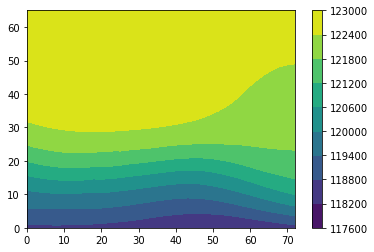

In [66]:
plt.contourf(shour['z'])
plt.colorbar()

In [81]:
ipos = np.where(shour['z'].values == np.percentile(shour['z'].values,99.9, interpolation='nearest'))
#ipos = np.unravel_index(pos, shour['z'].shape, order='C')

In [82]:
ipos

(array([42, 62]), array([21, 10]))

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


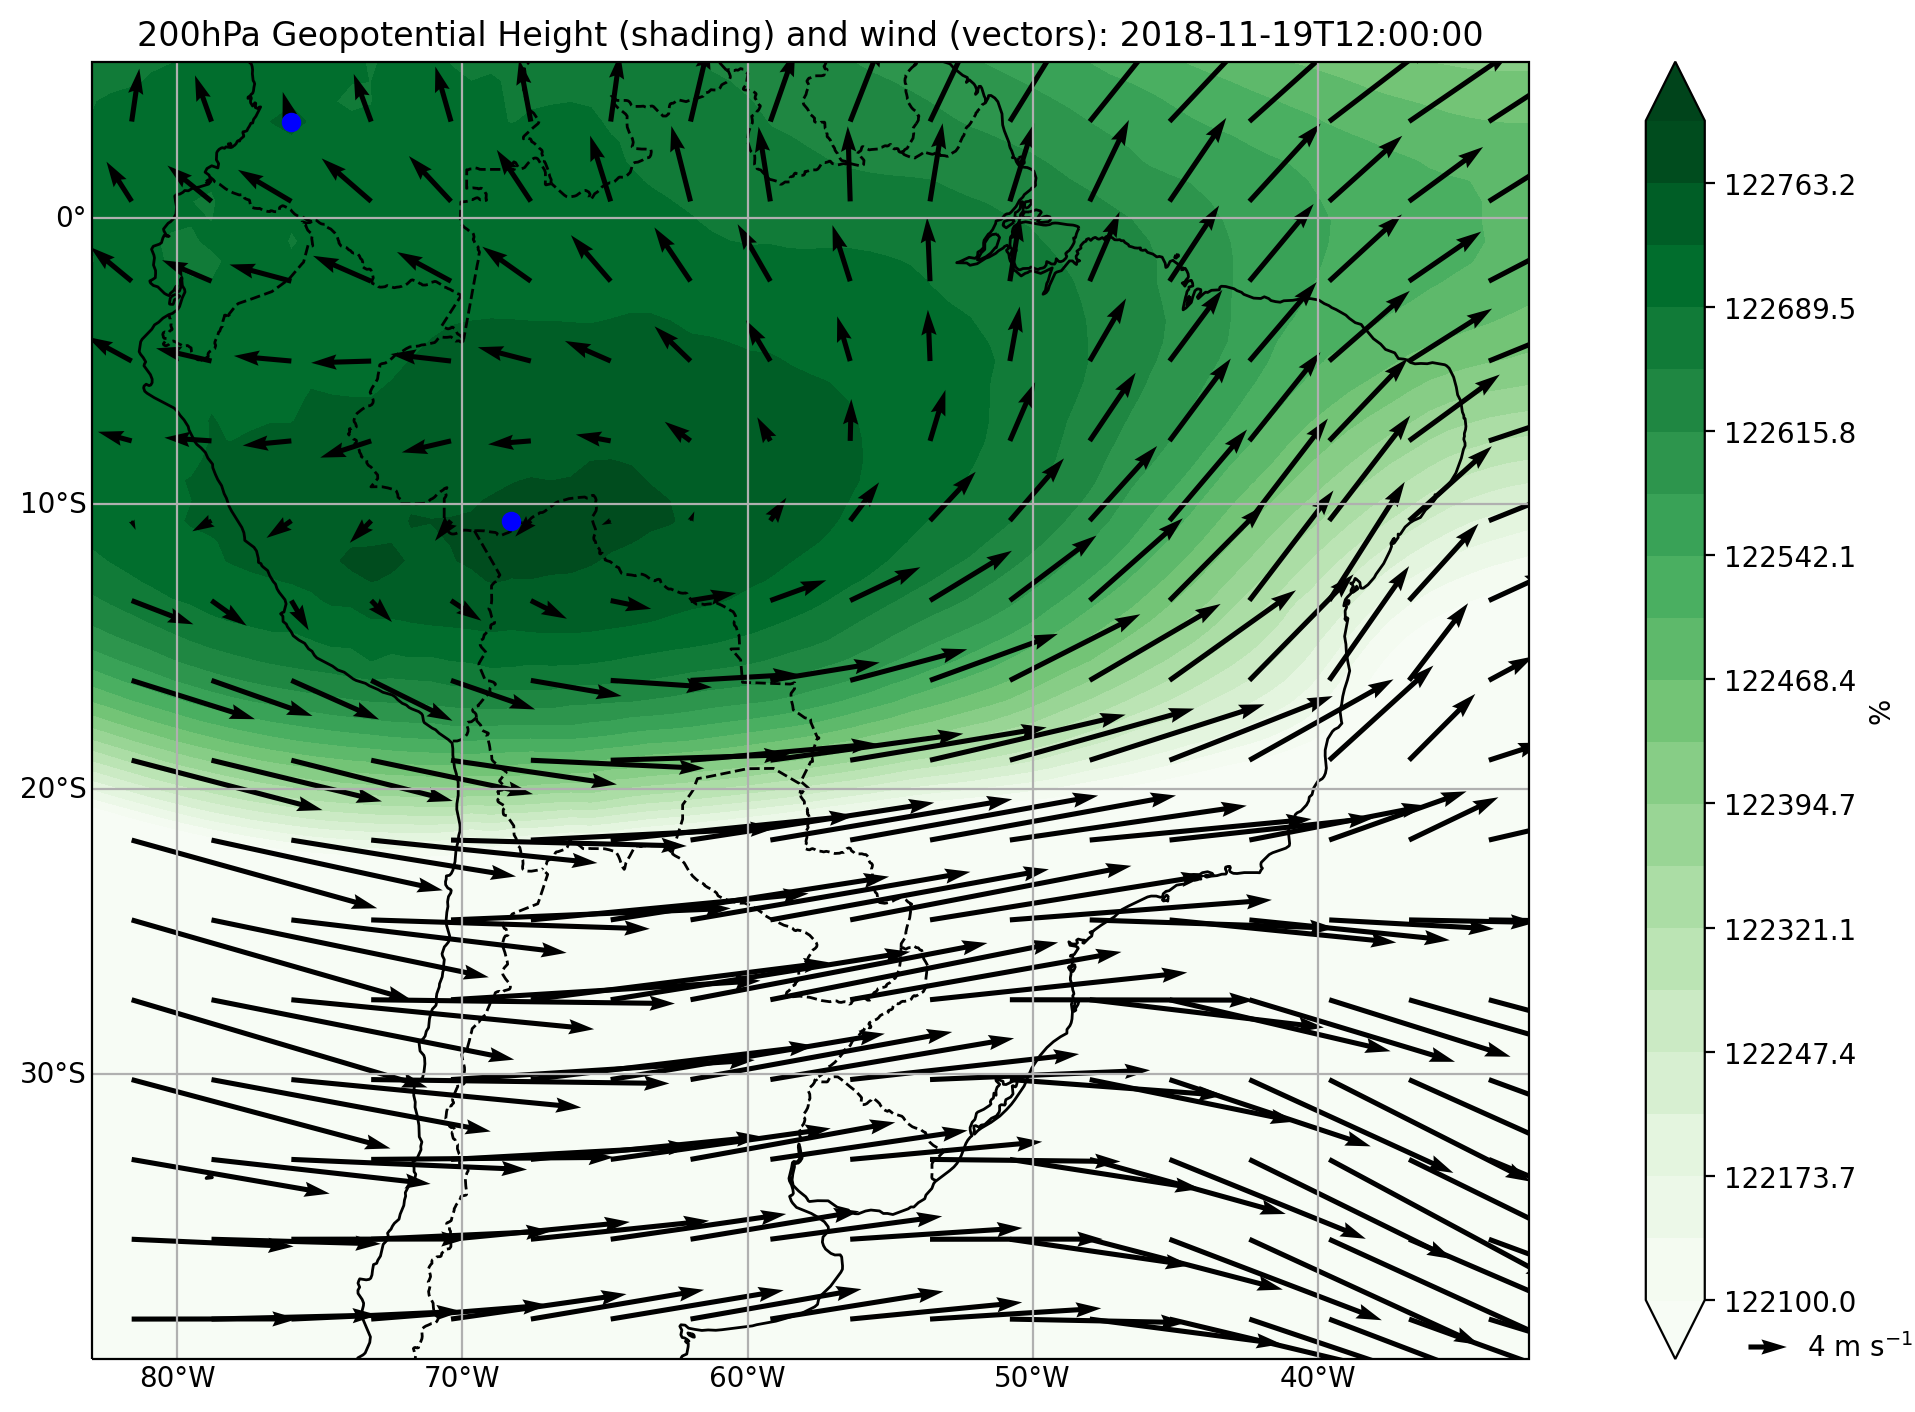

In [84]:
f=plt.figure(figsize=(12,7), dpi=200)  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map_wind(ax, shour['z'], shour.longitude, shour.latitude, title='200hPa Geopotential Height (shading) and wind (vectors): 2018-11-19T12:00:00',  quiver=qin, contour=None, cbar_label='%', cmap='Greens', levels=np.linspace(122100,122800, 20), extend='both')
ax.plot(shour.longitude[ipos[1]], shour.latitude[ipos[0]], 'bo')
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/simon/era5_geopot_march2016')

In [21]:
# make salem grid
grid = u_grid.make(mdic['lon'].values, mdic['lat'].values, 5000)
inds, weights, shape = u_int.interpolation_weights_grid(mdic['lon'].values, mdic['lat'].values, grid)
gridd = (inds,weights,shape, grid)


In [22]:
outt = u_int.interpolate_data(mdic['t'].values, inds, weights, shape)

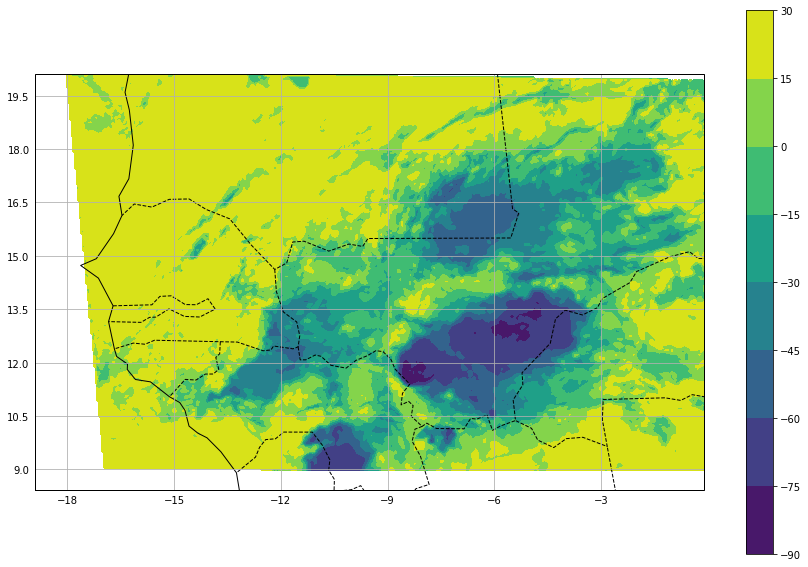

In [30]:
draw_map(outt, grid.ll_coordinates[1], grid.ll_coordinates[0])

In [27]:
grid.ll_coordinates

(array([[-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        ...,
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323]]),
 array([[ 8.93017387,  8.93017387,  8.93017387, ...,  8.93017387,
          8.93017387,  8.93017387],
        [ 8.97483424,  8.97483424,  8.97483424, ...,  8.97483424,
          8.97483424,  8.97483424],
        [ 9.01948904,  9.01948904,  9.01948904, ...,  9.01948904,
          9.01948904,  9.01948904],
        ...,
        [20.026321